# Readmission Modeling (Pipelines + Stratified K-Fold CV)

This notebook builds a **reproducible** baseline for a real-world tabular ML task:
**predicting hospital readmission within 30 days** (`readmission_30d`).

What you will get at the end:
- A **model comparison table**
- A **clear final model decision** (based primarily on PR-AUC)
- A chosen **decision threshold** with a transparent precision/recall trade-off
- Saved artifacts in `artifacts/` for later phases (API, MLflow, Docker)


In [1]:
from __future__ import annotations

from pathlib import Path
import sys

import pandas as pd
import matplotlib.pyplot as plt

def find_project_root(start: Path | None = None) -> Path:
    """Walk upwards to find the project root (folder containing 'data' and 'src')."""
    start = start or Path.cwd()
    cur = start.resolve()
    for _ in range(10):
        if (cur / "data").exists() and (cur / "src").exists():
            return cur
        if cur.parent == cur:
            break
        cur = cur.parent
    raise RuntimeError("Could not locate project root. Run the notebook from inside the project folder.")

ROOT = find_project_root()
SRC_DIR = ROOT / "src"
sys.path.insert(0, str(SRC_DIR))

DB_PATH = ROOT / "data" / "processed" / "readmission.duckdb"
ART_DIR = ROOT / "artifacts"
ART_DIR.mkdir(parents=True, exist_ok=True)

print("Project root:", ROOT)
print("DB path:", DB_PATH)
print("Artifacts:", ART_DIR)


Project root: C:\Users\amirm\Programming\Data Science Portfolio\projects\health-readmission-risk
DB path: C:\Users\amirm\Programming\Data Science Portfolio\projects\health-readmission-risk\data\processed\readmission.duckdb
Artifacts: C:\Users\amirm\Programming\Data Science Portfolio\projects\health-readmission-risk\artifacts


## 1) Load data from DuckDB

In [2]:
import train  # src/train.py

df = train.load_encounters(DB_PATH, table="encounters")
print("Raw shape:", df.shape)

X, y = train.prepare_xy(df, target_col="readmission_30d")
print("X shape:", X.shape)
print("Positive rate:", float(y.mean()))


Raw shape: (101766, 52)
X shape: (101766, 47)
Positive rate: 0.11159915885462728


## 2) Evaluate candidate models with Stratified K-Fold CV

In [3]:
models = train.build_models(random_state=42)

results = []
threshold_tables = {}

for name, est in models.items():
    res, oof_proba, tbl = train.evaluate_model_cv(
        model_name=name,
        estimator=est,
        X=X,
        y=y,
        n_splits=5,
        random_state=42
    )
    results.append(res.__dict__)
    threshold_tables[name] = tbl

df_results = pd.DataFrame(results).sort_values(by=["pr_auc", "roc_auc"], ascending=False)
df_results


,model_name,roc_auc,pr_auc,precision,recall,f1,threshold
1,rf,0.667159,0.216779,0.154760,0.723695,0.254991,0.21
0,logreg,0.648876,0.199372,0.149599,0.703619,0.246739,0.45


In [ ]:
# Persist results table for the repository
df_results.to_csv(ART_DIR / "cv_results.csv", index=False)
print("Saved:", ART_DIR / "cv_results.csv")


### Notes on metrics

- **PR-AUC** (Average Precision) is typically the most informative metric when positives are rare.
- **ROC-AUC** is still useful but can look optimistic under class imbalance.
- Precision / Recall / F1 depend on a **decision threshold**; we choose it using an explicit policy:
  1) Prefer thresholds with **recall ≥ 0.70**
  2) Among them, pick the best **F1**
  3) If none meets the recall constraint, pick the threshold that maximizes **F1**


## 3) Final model decision (based on PR-AUC)

In [4]:
best_row = df_results.iloc[0].to_dict()
best_model_name = best_row["model_name"]
best_threshold = float(best_row["threshold"])

best_model_name, best_threshold, best_row


('rf',
 0.20999999999999996,
 {'model_name': 'rf',
  'roc_auc': 0.6671590838566697,
  'pr_auc': 0.21677889129561626,
  'precision': 0.15476011147096483,
  'recall': 0.7236946376683984,
  'f1': 0.25499108043124175,
  'threshold': 0.20999999999999996})

**Decision statement**  
We select the final model as the one with the highest **PR-AUC** under Stratified K-Fold CV, using ROC-AUC as a tie-breaker.
We also report a **chosen threshold** to make the precision/recall trade-off explicit.


## 4) Threshold trade-off curve for the selected model

In [5]:
tbl = threshold_tables[best_model_name].copy()
tbl.head()


,threshold,precision,recall,f1
0,0.05,0.111805,0.999912,0.201121
1,0.06,0.111960,0.999296,0.201359
2,0.07,0.112256,0.998503,0.201822
3,0.08,0.112763,0.997094,0.202612
4,0.09,0.113480,0.993748,0.203698


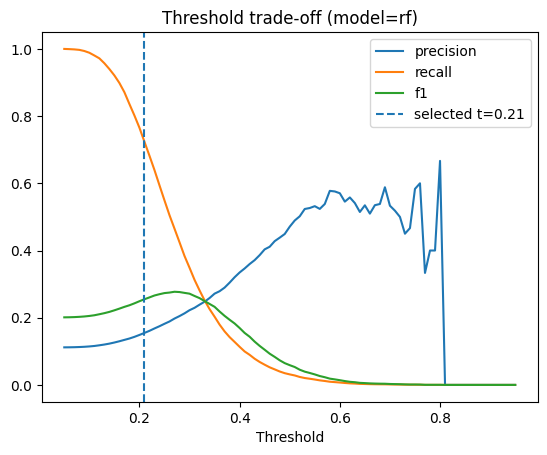

In [6]:
plt.figure()
plt.plot(tbl["threshold"], tbl["precision"], label="precision")
plt.plot(tbl["threshold"], tbl["recall"], label="recall")
plt.plot(tbl["threshold"], tbl["f1"], label="f1")
plt.axvline(best_threshold, linestyle="--", label=f"selected t={best_threshold:.2f}")
plt.xlabel("Threshold")
plt.title(f"Threshold trade-off (model={best_model_name})")
plt.legend()
plt.show()


In [ ]:
# Save threshold analysis for the selected model
tbl.to_csv(ART_DIR / "threshold_analysis.csv", index=False)
print("Saved:", ART_DIR / "threshold_analysis.csv")


## 5) Fit final model on all data and save artifacts

In [ ]:
final_estimator = models[best_model_name]
final_pipe = train.fit_final_model(final_estimator, X, y, random_state=42)

import joblib, json

joblib.dump(final_pipe, ART_DIR / "model.joblib")

with open(ART_DIR / "threshold.json", "w", encoding="utf-8") as f:
    json.dump({"model_name": best_model_name, "threshold": best_threshold}, f, indent=2)

print("Saved:", ART_DIR / "model.joblib")
print("Saved:", ART_DIR / "threshold.json")
